# Modul 1

In [19]:
from scipy.stats.distributions import chi2
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import pandas as pd
from os.path import normpath, dirname
import json
import git
from cycler import cycler
from itertools import cycle
from header import *
from math import floor, log10
from lmfit import Model

Functions

In [20]:
label_size = 22
plt.rcParams.update(
    {
        "font.size": label_size,
        "legend.title_fontsize": 22,
        "legend.fontsize": 22,
        "axes.labelsize": label_size,
        "xtick.labelsize": label_size,
        "ytick.labelsize": label_size,
        "axes.labelpad": 4,
        "lines.markersize": 13,
        "lines.linewidth": 2,
    }
)

# This will bind the paths from localSettings.json to objects in a class named paths
# usage: paths.<name>
class JSONObject:
    def __init__(self, dict):
        vars(self).update(dict)
def get_header(filename):
    with open(filename, "r") as f:
        for line in f:
            if line.startswith("#"):
                header = line
            else:
                break  # stop when there are no more #

        header = header[1:].strip().split()
    return header


def na(array):
    return np.array(array)


def quadratic(x, a):
    y = a * x ** 2
    return y


def polynomiell(x, a, b):
    y = a*x + b*x**2
    # a * x + b * x ** 2
    return y

def polynomiell_error(x, a, b, D_a, D_b):
    y = np.abs(x*D_a) + np.abs(2*b*x*D_b)
    return y

def polynomiell_exp(x, a, b, c):
    y = a*x + b*x**2 + np.exp(c*x)
    # a * x + b * x ** 2 + c*e^(d*x)
    return y

def polynomiell_exp_error(x, a, b, c, D_a, D_b, D_c):
    y = np.abs(x*D_a) + np.abs(2*b*x*D_b) + np.abs(c*np.exp(c*x)*D_c)
    return y

def exponential(x, a, b, c):
    y = a * np.exp(b * x) + c
    return y


def fehler_quadrat(N_model, N):
    sum_fehler2 = 0
    for i in np.arange(len(N)):
        sum_fehler2 = (N_model[i] - N[i]) ** 2
    return sum_fehler2
    # return np.sum(((N_model-N)**2)/N)


def RMSE(N_model, N):
    sum_fehler2 = 0
    for i in np.arange(len(N)):
        sum_fehler2 = (N_model[i] - N[i]) ** 2
    return np.sqrt(sum_fehler2 / len(N))
    
def round_to_n(data, n=1):
    if n != 1:
        return [round(x, -int(floor(log10(x))) + (n - 1)) for x in data]
    else:
        return [round(x, -int(floor(log10(x)))) for x in data]

# returns data and error rounded to significance of error
def round_to_reference(data, ref, n):
    ref = round_to_n(ref, n)
    return ([round(x, -int(floor(log10(y))) + (n - 1)) for (x,y) in zip(data, ref)], ref)

rtr = round_to_reference


# For PC in university, if conda does not want to install a package, do it by hand
# conda install -n myEnv --use-local myPackageFromAnaconda.tar.bz2
# https://github.com/conda/conda/issues/7245

# Force install for pip
# /bin/python3 -m pip install ipykernel -U --user --force-reinstall
# /bin/python3.6 -m pip install numpy -U --user


# Root Directory of Repository
repo = git.Repo(".", search_parent_directories=True).working_dir
with open(normpath(repo + "/localSettings.json"), "r") as f:
    path_data = f.read()
paths = json.loads(path_data, object_hook=JSONObject)

def fit_function_N (N, x_c, a, b):
    return np.array(x_c + a*N**(-b))

def fit_function_N_err (N, x_c, a, b, D_x_c, D_a, D_b):
    return np.array(D_x_c + N**(-b)*D_a+np.log(N)*a/(N**b)*D_b)

def compute_residual_and_error (fit_function, fit_function_error, data_x, data_y, args_fit, args_err):
    fit = fit_function(data_x, *args_fit)
    fit_error = fit_function_error(data_x, *args_fit, *args_err)
    residuals = data_y - fit
    residuals_err_lower = np.abs(data_y - (fit - fit_error))
    residuals_err_upper = np.abs(data_y - (fit + fit_error))
    residuals_err = np.array([residuals_err_lower, residuals_err_upper])
    return (residuals, residuals_err)

def compute_residual_and_diff_var (fit_function, data_x, data_y, data_y_error, args_fit):
    fit = fit_function(data_x, *args_fit)
    residuals = data_y - fit
    residuals_err_upper = np.abs((data_y + data_y_error) - fit)
    residuals_err_lower = np.abs((data_y - data_y_error) - fit)
    residuals_err = np.array([data_y_error, data_y_error])
    return (residuals, residuals_err)

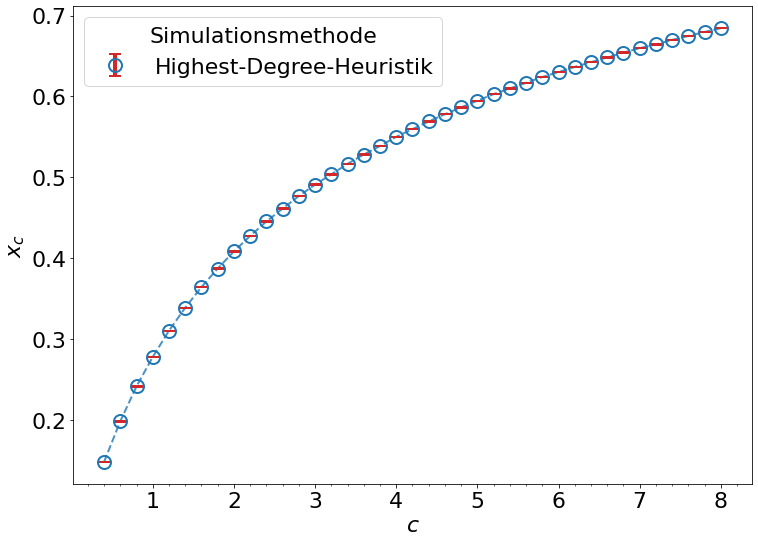

In [21]:
df = 8 # Number of degrees of freedom
path = normpath(paths.Modul1+'Data/Xc/Auswertung/plot_xc_gnu_High_deg.dat')
data_mod1 = pd.read_csv(path, sep=" ", comment='#', names=get_header(path))

c, x_c, x_c_err = na(data_mod1['c']), na(data_mod1['x_c']), na(data_mod1['x_c_err'])
fig, ax = plt.subplots(figsize=(11,8), tight_layout=True)
ax.errorbar(c, x_c, x_c_err, zorder=3, label="Highest-Degree-Heuristik", c="C0", fmt="o", ecolor="C3", elinewidth=4, capsize=6, fillstyle="none", markeredgewidth=2)
ax.plot(c, x_c, ls = "--", c="C0", alpha=0.8, zorder=2)


ax.set_xlabel('$c$')
ax.set_ylabel('$x_c$')
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.legend(title="Simulationsmethode")
plt.savefig('Abb/Mod1_high_deg.png')

Plot Reduced Chi-Squared

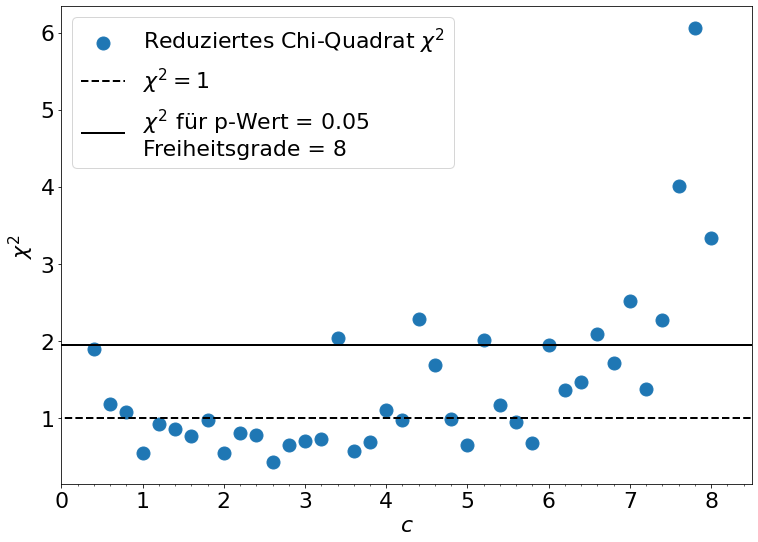

In [22]:
fig, ax = plt.subplots(figsize=(11,8), tight_layout=True)
ax.scatter(data_mod1['c'], data_mod1['chi_square'], label='Reduziertes Chi-Quadrat $\chi^2$')
ax.hlines(y=1, xmin=-1, xmax=10, ls='--', label='$\chi^2 = 1$')
# Get the maximum of chi-squared that would be acceptable 
chi_max = chi2.ppf(0.95, df)
chi_red_max = chi_max/df
ax.hlines(y=chi_red_max, xmin=-1, xmax=10, ls='-', label='$\chi^2$ für p-Wert = 0.05\nFreiheitsgrade = 8')

ax.set_xlabel('$c$')
ax.set_ylabel('$\chi^2$')
ax.set_xlim(0,8.5)
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.legend()
plt.savefig('Abb/Mod1_high_deg_chi_squared_red.png')

Residuen mit Fehler

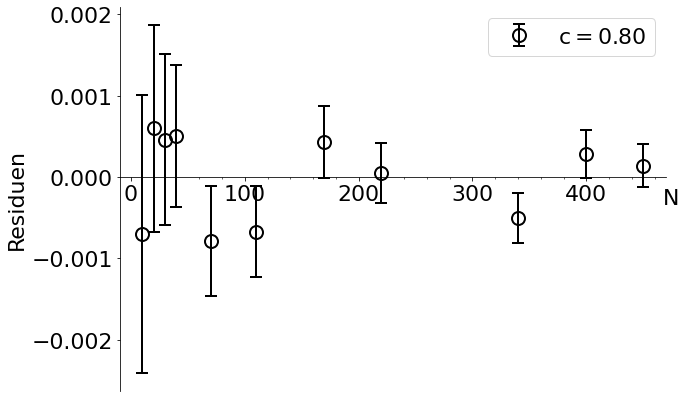

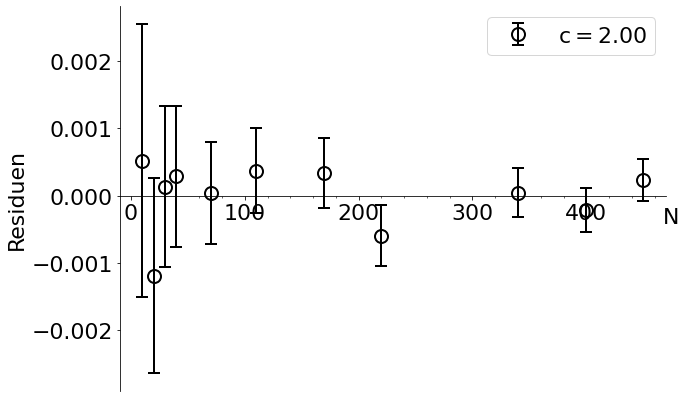

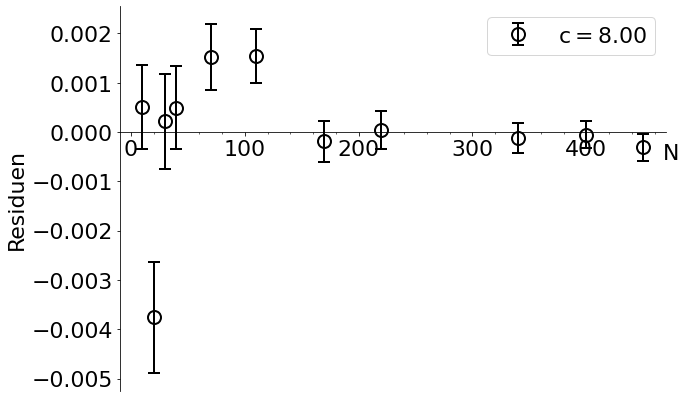

In [23]:
# x_c, a, b, D_x_c, D_a, D_b = 0.14771, 0.190, 1.09, 0.00027, 0.089, 0.17 # c=0.40
args_fit = [[0.241195, 0.296734, 1.14168],[0.408133, 0.31384, 1.06823 ],[0.684419, 3.59348, 1.5252]]
args_err = [[0.0002399, 0.09456, 0.1191],[0.0002189, 0.06311, 0.07412],[0.0002941, 0.4273, 0.0502]]

for i, (c, args_fit, args_err) in enumerate(zip(["0.80", "2.00", "8.00"], args_fit, args_err)):

    fig, ax = plt.subplots(figsize=(10,6), tight_layout=True)
    # Round numbers
    (args_fit, args_err) = rtr(args_fit, args_err, 2)

    path = normpath(paths.Modul1+f'Data/Xc/Xc_for_c{c}_high_deg_heur.dat')
    data = pd.read_csv(path, sep="\t", comment='#', names=get_header(path))

    # (residuals, residuals_err) = compute_residual_and_error(fit_function_N, fit_function_N_err, data['n'], data['cov_av'], args_fit, args_err)
    (residuals, residuals_err) = compute_residual_and_diff_var(fit_function_N, data['n'], data['cov_av'], data['cov_st'], args_fit)
    # residuals_err=None

    ax.errorbar(data['n'], residuals, residuals_err, label=f'c$={c}$', c="k", fmt="o", ecolor="k", elinewidth=2, capsize=6, fillstyle="none", markeredgewidth=2)
    # ax.hlines(y=0, xmin=-1, xmax=500, ls='--')

    # ax.xaxis.set_xlabel('$N$')
    # ax.set_xlabel("Data")
    plt.xlabel('N', horizontalalignment='right', verticalalignment='bottom', x=1.025)
    ax.set_ylabel('Residuen')
    ax.set_xlim(-10,470)
    # ax.xaxis.set_minor_locator(MultipleLocator(50))
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_position('zero')
    ax.legend()
    plt.savefig(f'Abb/Mod1_high_deg_Residuen_c_{c}.png')

# Modul 2

Laufzeit siehe eigenes Jupyter Notebook

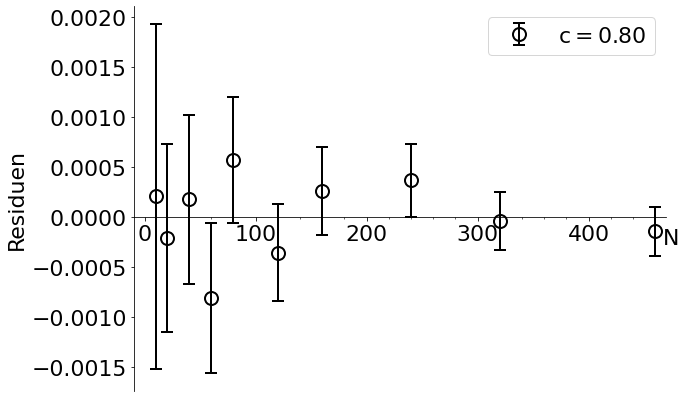

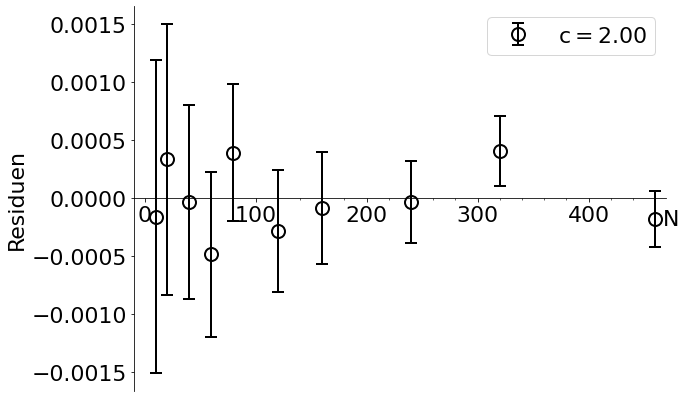

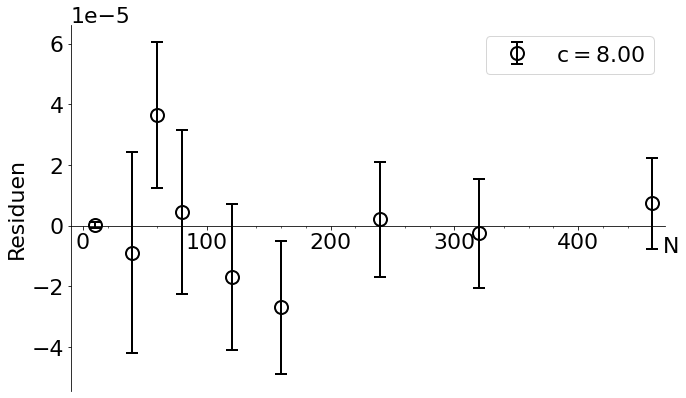

In [24]:
# x_c, a, b, D_x_c, D_a, D_b = 0.14771, 0.190, 1.09, 0.00027, 0.089, 0.17 # c=0.40
args_fit = [[0.237629, 0.278629, 1.10428],[0.392273, 0.276582, 1.04828 ],[0.499732, 0.000479764, 0.252398]]
args_err = [[0.0002063, 0.06402, 0.08565],[0.0002033, 0.04401, 0.06196],[0.0001329, 3.347e-05, 0.1918]]

for i, (c, args_fit, args_err) in enumerate(zip(["0.80", "2.00", "8.00"], args_fit, args_err)):

    fig, ax = plt.subplots(figsize=(10,6), tight_layout=True)
    # Round numbers
    (args_fit, args_err) = rtr(args_fit, args_err, 2)

    path = normpath(paths.Modul2+f'Aufg4/Aufg5/Auswertung/Aufg7/Xc_for_c{c}_Basic.dat')
    data = pd.read_csv(path, sep="\t", comment='#', names=get_header(path))

    # (residuals, residuals_err) = compute_residual_and_error(fit_function_N, fit_function_N_err, data['n'], data['cov_av'], args_fit, args_err)
    (residuals, residuals_err) = compute_residual_and_diff_var(fit_function_N, data['n'], data['cov_av'], data['cov_st'], args_fit)
    # residuals_err=None

    ax.errorbar(data['n'], residuals, residuals_err, label=f'c$={c}$', c="k", fmt="o", ecolor="k", elinewidth=2, capsize=6, fillstyle="none", markeredgewidth=2)
    # ax.hlines(y=0, xmin=-1, xmax=500, ls='--')

    # ax.xaxis.set_xlabel('$N$')
    # ax.set_xlabel("Data")
    plt.xlabel('N', horizontalalignment='right', verticalalignment='bottom', x=1.025)
    ax.set_ylabel('Residuen')
    ax.set_xlim(-10,470)
    # ax.xaxis.set_minor_locator(MultipleLocator(50))
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_position('zero')
    ax.legend()
    plt.savefig(f'Abb/Mod2_high_deg_Residuen_c_{c}.png')

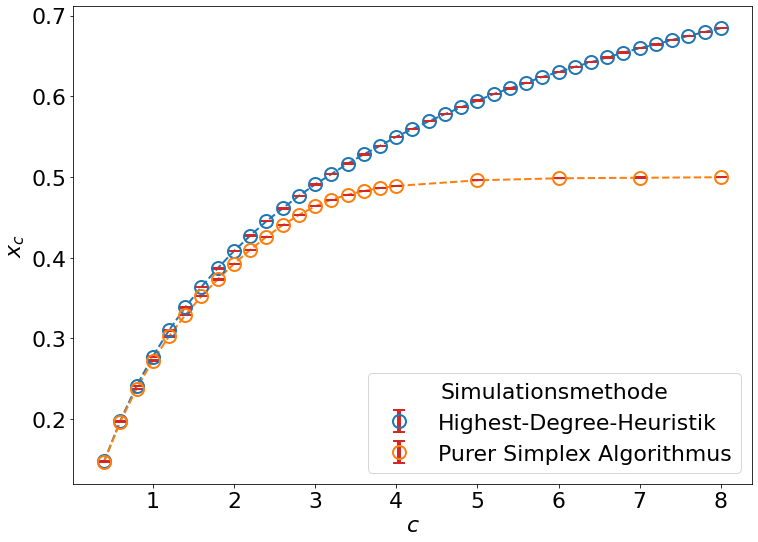

In [27]:
path = normpath(paths.Modul2+'Aufg4/Aufg5/Auswertung/Aufg7/plot_xc_gnu_Basic.dat')
data_mod2 = pd.read_csv(path, sep=" ", comment='#', names=get_header(path))
# df = 8 # Number of degrees of freedom
fig, ax = plt.subplots(figsize=(11,8))
# Module 1
ax.errorbar(data_mod1['c'], data_mod1['x_c'], data_mod1['x_c_err'], zorder=3, label="Highest-Degree-Heuristik", c="C0", fmt="o", ecolor="C3", elinewidth=4, capsize=6, fillstyle="none", markeredgewidth=2)
ax.plot(data_mod1['c'], data_mod1['x_c'], ls = "--", c="C0", alpha=1, zorder=2)

# Module 2
ax.errorbar(data_mod2['c'], data_mod2['x_c'], data_mod2['x_c_err'], zorder=3, label="Purer Simplex Algorithmus", c="C1", fmt="o", ecolor="C3", elinewidth=4, capsize=6, fillstyle="none", markeredgewidth=2)
ax.plot(data_mod2['c'], data_mod2['x_c'], ls = "--", c="C1", alpha=1, zorder=2)

ax.set_xlabel('$c$')
ax.set_ylabel('$x_c$')
ax.legend(title="Simulationsmethode")
plt.tight_layout()
plt.savefig('Abb/Mod2_high_deg_pure_SX.png')

Reduced Chi-Square

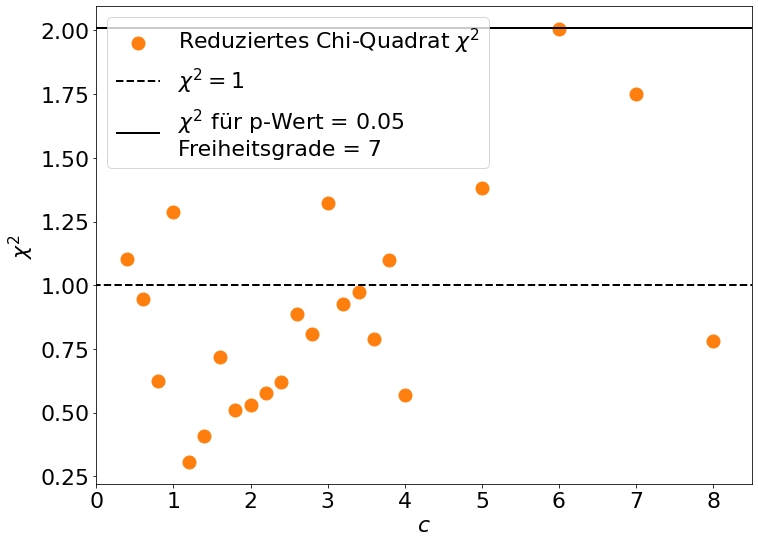

In [28]:
fig, ax = plt.subplots(figsize=(11,8))
ax.scatter(data_mod2['c'], data_mod2['chi_square'], c='C1', label='Reduziertes Chi-Quadrat $\chi^2$')
ax.hlines(y=1, xmin=-1, xmax=10, ls='--', color='k', label='$\chi^2 = 1$')
df=7
# Get the maximum of chi-squared that would be acceptable 
chi_max = chi2.ppf(0.95, df)
chi_red_max = chi_max/df
ax.hlines(y=chi_red_max, xmin=-1, xmax=10, color='k', ls='-', label='$\chi^2$ für p-Wert = 0.05\nFreiheitsgrade = 7')

ax.set_xlabel('$c$')
ax.set_ylabel('$\chi^2$')
ax.set_xlim(0,8.5)
ax.legend()
plt.tight_layout()
plt.savefig('Abb/Mod2_pure_SX_chi_squared_red.png')

# Modul 3

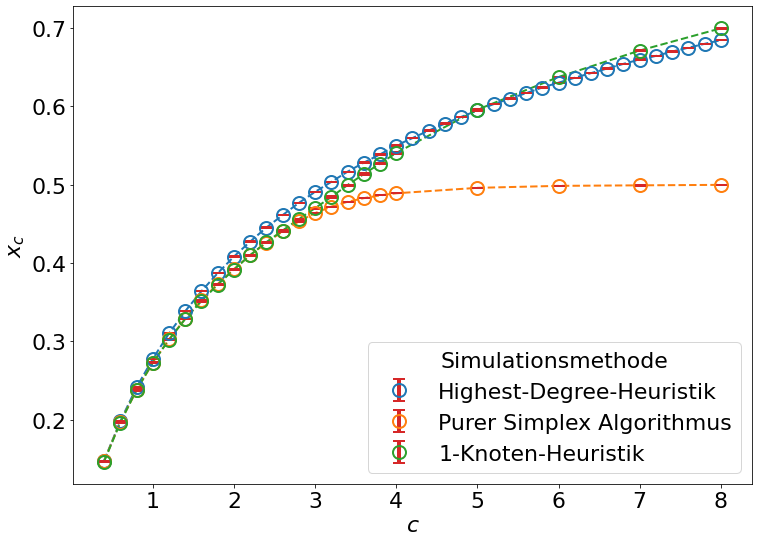

In [ ]:
path = normpath(paths.Modul3+'Aufg6/Auswertung/Aufg8/plot_xc_gnu_Heur.dat')
data_mod3 = pd.read_csv(path, sep=" ", comment='#', names=get_header(path))
# df = 8 # Number of degrees of freedom
fig, ax = plt.subplots(figsize=(11,8))
# Module 1
ax.errorbar(c, x_c, x_c_err, zorder=3, label="Highest-Degree-Heuristik", c="C0", fmt="o", ecolor="C3", elinewidth=4, capsize=6, fillstyle="none", markeredgewidth=2)
ax.plot(c, x_c, ls = "--", c="C0", alpha=1, zorder=2)

# Module 2
ax.errorbar(data_mod2['c'], data_mod2['x_c'], data_mod2['x_c_err'], zorder=3, label="Purer Simplex Algorithmus", c="C1", fmt="o", ecolor="C3", elinewidth=4, capsize=6, fillstyle="none", markeredgewidth=2)
ax.plot(data_mod2['c'], data_mod2['x_c'], ls = "--", c="C1", alpha=1, zorder=2)

# Module 3
ax.errorbar(data_mod3['c'], data_mod3['x_c'], data_mod3['x_c_err'], zorder=3, label="1-Knoten-Heuristik", c="C2", fmt="o", ecolor="C3", elinewidth=4, capsize=6, fillstyle="none", markeredgewidth=2)
ax.plot(data_mod3['c'], data_mod3['x_c'], ls = "--", c="C2", alpha=1, zorder=2)

ax.set_xlabel('$c$')
ax.set_ylabel('$x_c$')
ax.legend(title="Simulationsmethode")
plt.tight_layout()
plt.savefig('Abb/Mod3_high_deg_pure_SX_and_Knoten1.png')

Vergleich 0 und 1 Knotenheuristik

<ipython-input-16-902171400f8f>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_mod3_0_c_all = data_mod3_0_c0_6.append([data_mod3_0_c2, data_mod3_0_c6])


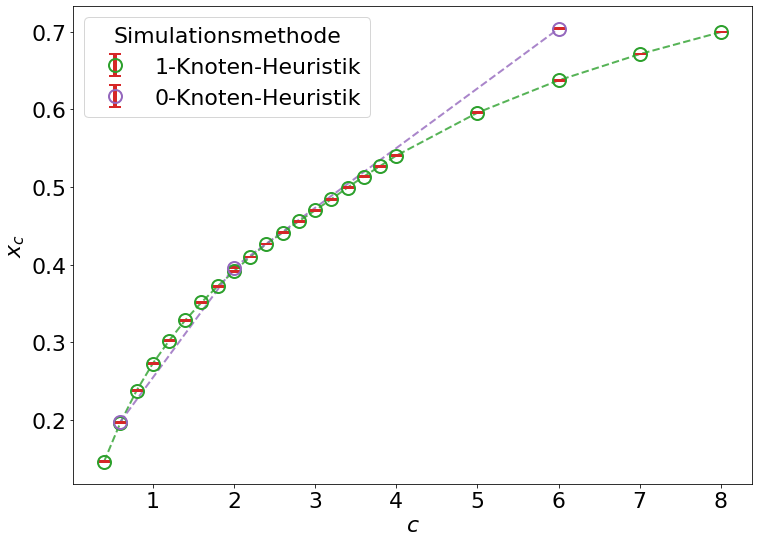

In [ ]:
path = normpath(paths.Modul3+'/Aufg5/Auswertung/VC_n100_means_m30-30_s1001-2001_Heur.dat')
header = get_header(path)
header.append("temp") # Because in the file we first have a space, which is detected as a NaN column
data_mod3_0_c0_6 = pd.read_csv(path, sep=" ", comment='#', names=header, skipinitialspace=True)
path = normpath(paths.Modul3+'/Aufg5/Auswertung/VC_n100_means_m100-100_s1001-2001_Heur.dat')
data_mod3_0_c2 = pd.read_csv(path, sep=" ", comment='#', names=header, skipinitialspace=True)
path = normpath(paths.Modul3+'/Aufg5/Auswertung/VC_n100_means_m300-300_s1001-2001_Heur.dat')
data_mod3_0_c6 = pd.read_csv(path, sep=" ", comment='#', names=header,skipinitialspace=True)

# df = 8 # Number of degrees of freedom
fig, ax = plt.subplots(figsize=(11,8))
data_mod3_0_c_all = data_mod3_0_c0_6.append([data_mod3_0_c2, data_mod3_0_c6])
data_mod3_0_c_all.drop('temp', axis=1, inplace=True)
# Module 3 Knoten = 1
ax.errorbar(data_mod3['c'], data_mod3['x_c'], data_mod3['x_c_err'], zorder=3, label="0-Knoten-Heuristik", c="C2", fmt="o", ecolor="C3", elinewidth=4, capsize=6, fillstyle="none", markeredgewidth=2)
ax.plot(data_mod3['c'], data_mod3['x_c'], ls = "--", c="C2", alpha=0.8, zorder=2)

# # Module 3 Knoten = 0
ax.errorbar(data_mod3_0_c_all['c'], data_mod3_0_c_all['x'], data_mod3_0_c_all['x_err'], zorder=3, label="1-Knoten-Heuristik", c="C4", fmt="o", ecolor="C3", elinewidth=4, capsize=6, fillstyle="none", markeredgewidth=2)
ax.plot(data_mod3_0_c_all['c'], data_mod3_0_c_all['x'], ls = "--", c="C4", alpha=0.8, zorder=2)

ax.set_xlabel('$c$')
ax.set_ylabel('$x_c$')
ax.legend(title="Simulationsmethode")
plt.tight_layout()
plt.savefig('Abb/Mod3_SX_and_Knoten_1_0.png')

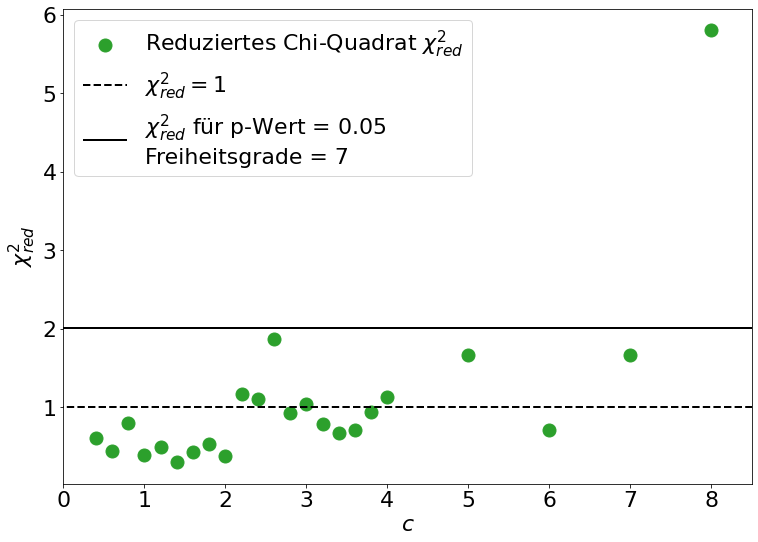

In [ ]:
fig, ax = plt.subplots(figsize=(11,8))
ax.scatter(data_mod3['c'], data_mod3['chi_square'], c='C2', label='Reduziertes Chi-Quadrat $\chi^2$')
ax.hlines(y=1, xmin=-1, xmax=10, ls='--',color='k', label='$\chi^2 = 1$')
df=7
# Get the maximum of chi-squared that would be acceptable 
chi_max = chi2.ppf(0.95, df)
chi_red_max = chi_max/df
ax.hlines(y=chi_red_max, xmin=-1, xmax=10, color='k', ls='-', label='$\chi^2$ für p-Wert = 0.05\nFreiheitsgrade = 7')

ax.set_xlabel('$c$')
ax.set_ylabel('$\chi^2$')
ax.set_xlim(0,8.5)
ax.legend()
plt.tight_layout()
plt.savefig('Abb/Mod2_pure_SX_chi_squared_red.png')

# Modul 4

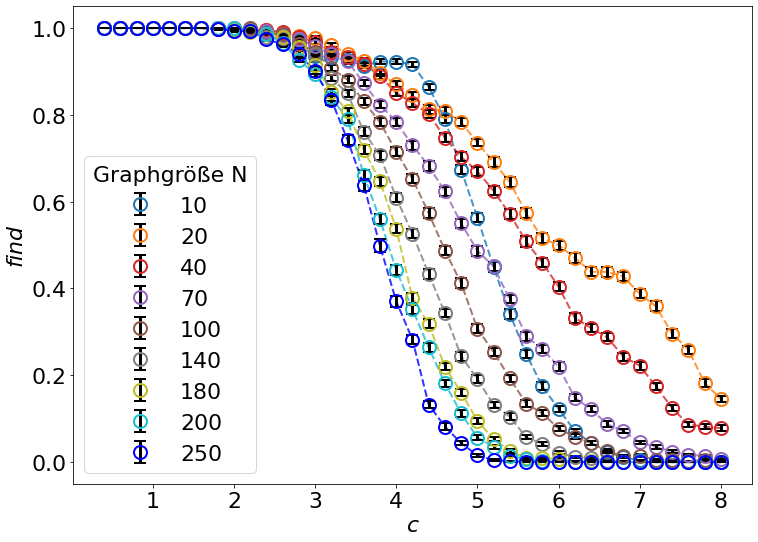

In [ ]:
N = [10, 20, 30, 40, 70, 100, 120, 140, 180, 200, 250]

# N = [10, 20,30,40,100]
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors = colors + ['b', 'g', 'm']
default_cycler = cycler(color=colors)

fig, ax = plt.subplots(figsize=(11,8), tight_layout=True)
for n, sty in zip(N,default_cycler):
    path = normpath(paths.Modul4+f'/Aufg5/Aufg6/VC_n{n}_means_m{int(2*n/10)}-{int(4*n)}_s1001-2001_add1_max_m100000_search5_CP.dat')
    header = get_header(path)
    header.append("temp") # Because in the file we first have a space, which is detected as a NaN column
    data_mod4 = pd.read_csv(path, sep=" ", comment='#', names=header, skipinitialspace=True)
    data_mod4.drop('temp', axis=1, inplace=True)

    if n != 120 and n!=30:
        ax.errorbar(data_mod4['c'], data_mod4['find'], data_mod4['find_err'], **sty, zorder=3, label=f"{n}", fmt="o", ecolor="black", elinewidth=3, capsize=6, fillstyle="none", markeredgewidth=2)
        ax.plot(data_mod4['c'], data_mod4['find'], **sty, ls = "--", alpha=0.8, zorder=2)
        # ax.scatter(data_mod4['c'], data_mod4['find'], **sty, alpha=0.8, zorder=2, label=f"{n}")    

ax.set_xlabel('$c$')
ax.set_ylabel('$find$')
ax.legend(title="Graphgröße N")
plt.savefig('Abb/Mod4_SX_Cutting_Planes_find.png')

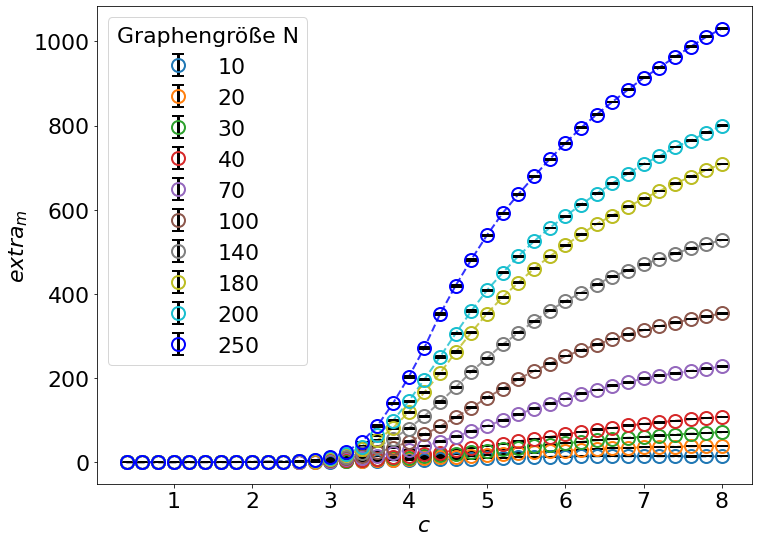

In [ ]:
# N = [10, 20,30,40,100]
default_cycler = cycler(color=colors)

fig, ax = plt.subplots(figsize=(11,8), tight_layout=True)
for n, sty in zip(N,default_cycler):
    path = normpath(paths.Modul4+f'/Aufg5/Aufg6/VC_n{n}_means_m{int(2*n/10)}-{int(4*n)}_s1001-2001_add1_max_m100000_search5_CP.dat')
    header = get_header(path)
    header.append("temp") # Because in the file we first have a space, which is detected as a NaN column
    data_mod4 = pd.read_csv(path, sep=" ", comment='#', names=header, skipinitialspace=True)
    data_mod4.drop('temp', axis=1, inplace=True)

    if n != 120:
        ax.errorbar(data_mod4['c'], data_mod4['extra_m'], data_mod4['extra_m_err'], **sty, zorder=3, label=f"{n}", fmt="o", ecolor="black", elinewidth=3, capsize=6, fillstyle="none", markeredgewidth=2)
        ax.plot(data_mod4['c'], data_mod4['extra_m'], **sty, ls = "--", alpha=0.8, zorder=2)
        # ax.scatter(data_mod4['c'], data_mod4['find'], **sty, alpha=0.8, zorder=2, label=f"{n}")    

ax.set_xlabel('$c$')
ax.set_ylabel('$extra_m$')
ax.legend(title="Graphengröße N")
plt.savefig('Abb/Mod4_SX_Cutting_Planes_extraM.png')

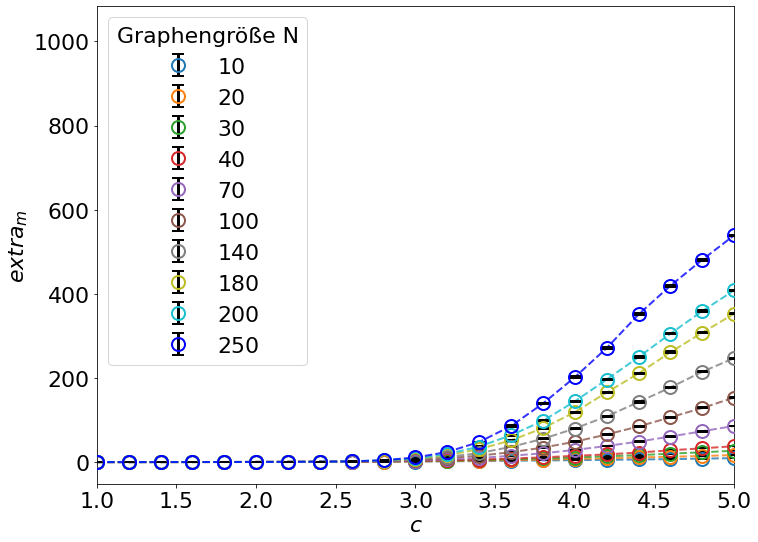

In [ ]:
# N = [10, 20,30,40,100]
default_cycler = cycler(color=colors)

fig, ax = plt.subplots(figsize=(11,8), tight_layout=True)
for n, sty in zip(N,default_cycler):
    path = normpath(paths.Modul4+f'/Aufg5/Aufg6/VC_n{n}_means_m{int(2*n/10)}-{int(4*n)}_s1001-2001_add1_max_m100000_search5_CP.dat')
    header = get_header(path)
    header.append("temp") # Because in the file we first have a space, which is detected as a NaN column
    data_mod4 = pd.read_csv(path, sep=" ", comment='#', names=header, skipinitialspace=True)
    data_mod4.drop('temp', axis=1, inplace=True)

    if n != 120:
        ax.errorbar(data_mod4['c'], data_mod4['extra_m'], data_mod4['extra_m_err'], **sty, zorder=3, label=f"{n}", fmt="o", ecolor="black", elinewidth=3, capsize=6, fillstyle="none", markeredgewidth=2)
        ax.plot(data_mod4['c'], data_mod4['extra_m'], **sty, ls = "--", alpha=0.8, zorder=2)
        # ax.scatter(data_mod4['c'], data_mod4['find'], **sty, alpha=0.8, zorder=2, label=f"{n}")    

ax.set_xlabel('$c$')
ax.set_ylabel('$extra_m$')
ax.set_xlim(1,5)
ax.legend(title="Graphengröße N")
plt.savefig('Abb/Mod4_SX_Cutting_Planes_extraM_zoomed.png')

N: 70, Peak: (c,find) = (5.0, 0.249777572577)
N: 100, Peak: (c,find) = (4.6, 0.249692490327)
N: 120, Peak: (c,find) = (4.4, 0.249759531178)
N: 140, Peak: (c,find) = (4.2, 0.249152750347)
N: 180, Peak: (c,find) = (4.0, 0.248427965641)
N: 200, Peak: (c,find) = (4.0, 0.246925065444)
N: 250, Peak: (c,find) = (3.8, 0.249809594191)


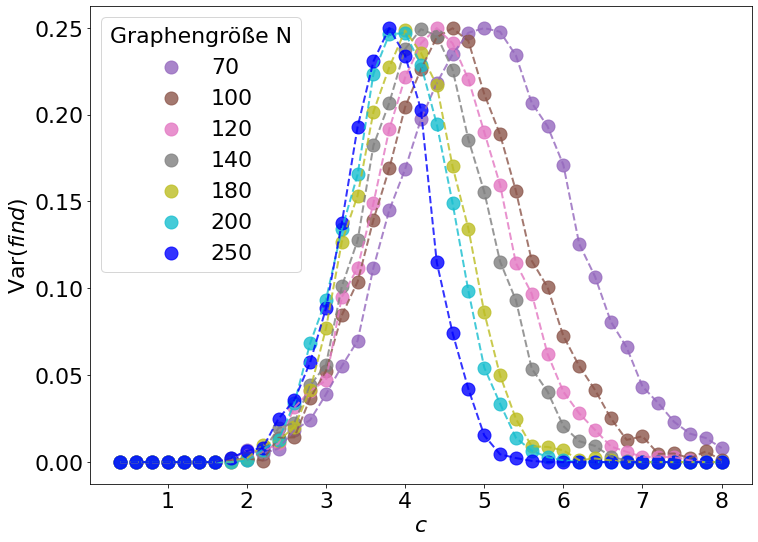

In [ ]:
# N = [10, 20,30,40,100]
default_cycler = cycler(color=colors)

fig, ax = plt.subplots(figsize=(11,8), tight_layout=True)
for n, sty in zip(N,default_cycler):
    path = normpath(paths.Modul4+f'/Aufg5/Aufg6/VC_n{n}_means_m{int(2*n/10)}-{int(4*n)}_s1001-2001_add1_max_m100000_search5_CP.dat')
    header = get_header(path)
    header.append("temp") # Because in the file we first have a space, which is detected as a NaN column
    data_mod4 = pd.read_csv(path, sep=" ", comment='#', names=header, skipinitialspace=True)
    data_mod4.drop('temp', axis=1, inplace=True)

    if n not in [10,20,30,40]:
        # ax.errorbar(data_mod4['c'], data_mod4['Var(find)'], data_mod4['Var(find)_err'], **sty, zorder=3, label=f"{n}", fmt="o", ecolor="black", elinewidth=3, capsize=6, fillstyle="none", markeredgewidth=2)
        ax.scatter(data_mod4['c'], data_mod4['Var(find)'], **sty, alpha=0.8, zorder=2, label=f"{n}")    
        ax.plot(data_mod4['c'], data_mod4['Var(find)'], **sty, ls = "--", alpha=0.8, zorder=2)
        idx_max = data_mod4[['Var(find)']].idxmax()
        print(f'N: {n}, Peak: (c,find) = ({float(data_mod4["c"][idx_max])}, {float(data_mod4["Var(find)"][idx_max])})')

ax.set_xlabel('$c$')
ax.set_ylabel('Var($find$)')
# ax.set_xlim(1,5)
ax.legend(title="Graphengröße N")
plt.savefig('Abb/Mod4_SX_Cutting_Planes_extraM_var.png')

In [ ]:
# delta_c = 0.02
# c_peak = [5, 4.6, 4.4, 4.2, 4.0, 4.0, 3.8]
# N = [70, 100, 120, 140, 180, 200, 250]
# c_dataframe = pd.DataFrame(columns=N)
# for cp, n in zip(c_peak, N):
#     c = cp - 0.4
#     cmax = cp + 0.4
#     c_list = []
#     while c <= cmax:
#         # M = c/2*n
#         if((c*n)%2 == 0):
#             c_list.append(c)
#         c += delta_c
#     print(f"N: {n}, c_list: {c_list}")

Finer c for Peaks

In [ ]:
# ./Simp_CP -n 250 -ci 3.24 -cf 4.44 -si 1001 -sf 2001 -max_extra_m 100000 -add 1 -search 5 &
# ./Simp_CP -n 250 -ci 3.28 -cf 4.48 -si 1001 -sf 2001 -max_extra_m 100000 -add 1 -search 5 &
# ./Simp_CP -n 250 -ci 3.32 -cf 4.52 -si 1001 -sf 2001 -max_extra_m 100000 -add 1 -search 5 &
# ./Simp_CP -n 250 -ci 3.36 -cf 4.56 -si 1001 -sf 2001 -max_extra_m 100000 -add 1 -search 5 &
# #
# ./Simp_CP -n 200 -ci 3.44 -cf 4.64 -si 1001 -sf 2001 -max_extra_m 100000 -add 1 -search 5 &
# ./Simp_CP -n 200 -ci 3.48 -cf 4.68 -si 1001 -sf 2001 -max_extra_m 100000 -add 1 -search 5 &
# ./Simp_CP -n 200 -ci 3.52 -cf 4.72 -si 1001 -sf 2001 -max_extra_m 100000 -add 1 -search 5 &
# ./Simp_CP -n 200 -ci 3.56 -cf 4.76 -si 1001 -sf 2001 -max_extra_m 100000 -add 1 -search 5 &
# #
# ./Simp_CP -n 180 -ci 3.44 -cf 4.64 -si 1001 -sf 2001 -max_extra_m 100000 -add 1 -search 5 &
# ./Simp_CP -n 180 -ci 3.48 -cf 4.68 -si 1001 -sf 2001 -max_extra_m 100000 -add 1 -search 5 &
# ./Simp_CP -n 180 -ci 3.52 -cf 4.72 -si 1001 -sf 2001 -max_extra_m 100000 -add 1 -search 5 &
# ./Simp_CP -n 180 -ci 3.56 -cf 4.76 -si 1001 -sf 2001 -max_extra_m 100000 -add 1 -search 5 &
# #
# ./Simp_CP -n 140 -ci 3.64 -cf 4.84 -si 1001 -sf 2001 -max_extra_m 100000 -add 1 -search 5 &
# ./Simp_CP -n 140 -ci 3.68 -cf 4.88 -si 1001 -sf 2001 -max_extra_m 100000 -add 1 -search 5 &
# ./Simp_CP -n 140 -ci 3.72 -cf 4.92 -si 1001 -sf 2001 -max_extra_m 100000 -add 1 -search 5 &
# ./Simp_CP -n 140 -ci 3.76 -cf 4.96 -si 1001 -sf 2001 -max_extra_m 100000 -add 1 -search 5 &
# #
# ./Simp_CP -n 120 -ci 3.84 -cf 5.04 -si 1001 -sf 2001 -max_extra_m 100000 -add 1 -search 5 &
# ./Simp_CP -n 120 -ci 3.88 -cf 5.08 -si 1001 -sf 2001 -max_extra_m 100000 -add 1 -search 5 &
# ./Simp_CP -n 120 -ci 3.92 -cf 5.12 -si 1001 -sf 2001 -max_extra_m 100000 -add 1 -search 5 &
# ./Simp_CP -n 120 -ci 3.96 -cf 5.16 -si 1001 -sf 2001 -max_extra_m 100000 -add 1 -search 5 &
# #
# ./Simp_CP -n 100 -ci 4.04 -cf 5.24 -si 1001 -sf 2001 -max_extra_m 100000 -add 1 -search 5 &
# ./Simp_CP -n 100 -ci 4.08 -cf 5.28 -si 1001 -sf 2001 -max_extra_m 100000 -add 1 -search 5 &
# ./Simp_CP -n 100 -ci 4.12 -cf 5.32 -si 1001 -sf 2001 -max_extra_m 100000 -add 1 -search 5 &
# ./Simp_CP -n 100 -ci 4.16 -cf 5.36 -si 1001 -sf 2001 -max_extra_m 100000 -add 1 -search 5 &
# #
# ./Simp_CP -n 70 -ci 4.24 -cf 5.44 -si 1001 -sf 2001 -max_extra_m 100000 -add 1 -search 5 &
# ./Simp_CP -n 70 -ci 4.28 -cf 5.48 -si 1001 -sf 2001 -max_extra_m 100000 -add 1 -search 5 &
# ./Simp_CP -n 70 -ci 4.32 -cf 5.52 -si 1001 -sf 2001 -max_extra_m 100000 -add 1 -search 5 &
# ./Simp_CP -n 70 -ci 4.36 -cf 5.56 -si 1001 -sf 2001 -max_extra_m 100000 -add 1 -search 5 &

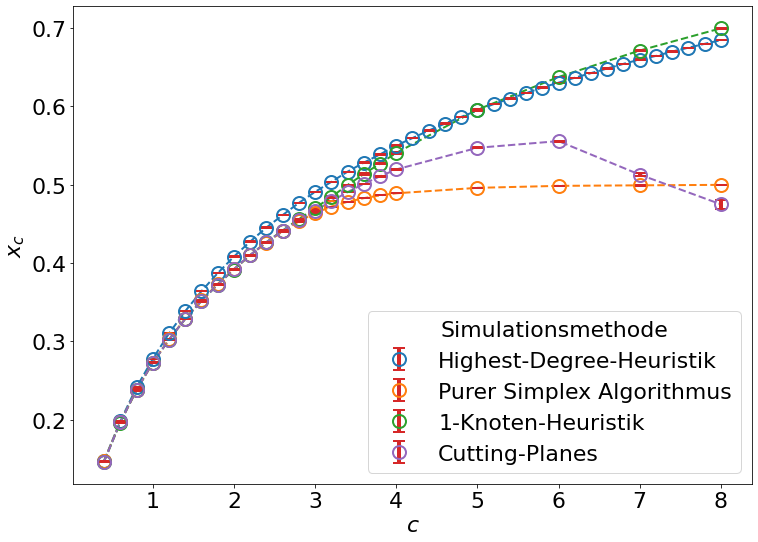

In [ ]:
path = normpath(paths.Modul4+'Aufg5/Aufg6/Aufg10/plot_xc_gnu_CP.dat')
data_mod4 = pd.read_csv(path, sep=" ", comment='#', names=get_header(path))
fig, ax = plt.subplots(figsize=(11,8))
# Module 1
ax.errorbar(c, x_c, x_c_err, zorder=3, label="Highest-Degree-Heuristik", c="C0", fmt="o", ecolor="C3", elinewidth=4, capsize=6, fillstyle="none", markeredgewidth=2)
ax.plot(c, x_c, ls = "--", c="C0", alpha=1, zorder=2)

# Module 2
ax.errorbar(data_mod2['c'], data_mod2['x_c'], data_mod2['x_c_err'], zorder=3, label="Purer Simplex Algorithmus", c="C1", fmt="o", ecolor="C3", elinewidth=4, capsize=6, fillstyle="none", markeredgewidth=2)
ax.plot(data_mod2['c'], data_mod2['x_c'], ls = "--", c="C1", alpha=1, zorder=2)

# Module 3
ax.errorbar(data_mod3['c'], data_mod3['x_c'], data_mod3['x_c_err'], zorder=3, label="-Knoten-Heuristik", c="C2", fmt="o", ecolor="C3", elinewidth=4, capsize=6, fillstyle="none", markeredgewidth=2)
ax.plot(data_mod3['c'], data_mod3['x_c'], ls = "--", c="C2", alpha=1, zorder=2)

# Module 4
ax.errorbar(data_mod4['c'], data_mod4['x_c'], data_mod4['x_c_err'], zorder=3, label="Cutting-Planes", c="C4", fmt="o", ecolor="C3", elinewidth=4, capsize=6, fillstyle="none", markeredgewidth=2)
ax.plot(data_mod4['c'], data_mod4['x_c'], ls = "--", c="C4", alpha=1, zorder=2)

ax.set_xlabel('$c$')
ax.set_ylabel('$x_c$')
ax.legend(title="Simulationsmethode")
plt.tight_layout()
plt.savefig('Abb/Mod3_high_deg_pure_SX_and_Knoten1_CP.png')

Reduziertes Chi Quadrat

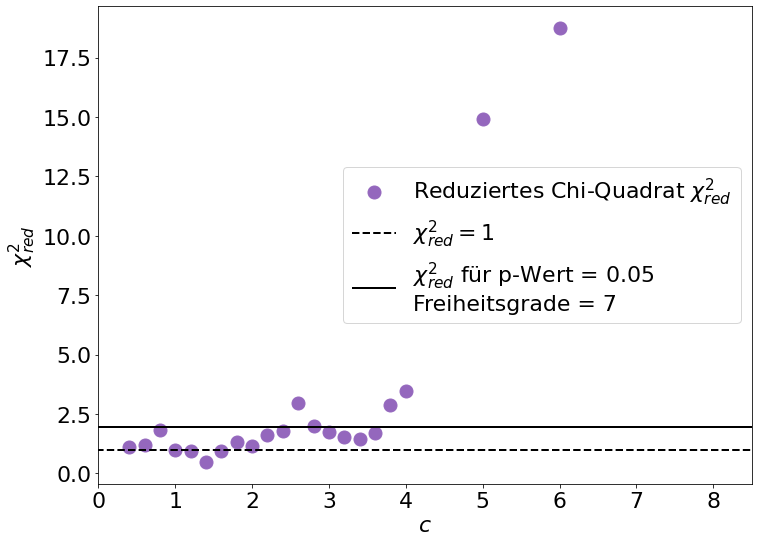

In [ ]:
fig, ax = plt.subplots(figsize=(11,8))
ax.scatter(data_mod4['c'][:-2], data_mod4['chi_square'][:-2], c='C4', label='Reduziertes Chi-Quadrat $\chi^2$')
ax.hlines(y=1, xmin=-1, xmax=10, ls='--', color='k', label='$\chi^2 = 1$')
df=8
# Get the maximum of chi-squared that would be acceptable 
chi_max = chi2.ppf(0.95, df)
chi_red_max = chi_max/df
ax.hlines(y=chi_red_max, xmin=-1, xmax=10, ls='-', color='k', label='$\chi^2$ für p-Wert = 0.05\nFreiheitsgrade = 7')

ax.set_xlabel('$c$')
ax.set_ylabel('$\chi^2$')
ax.set_xlim(0,8.5)
ax.legend()
plt.tight_layout()
plt.savefig('Abb/Mod4_CP_chi_squared_red.png')


In [ ]:
connectivities = [i/10. for i in range(4, 40, 2)] + [i for i in range(4, 8+1)]
connectivities

[0.4,
 0.6,
 0.8,
 1.0,
 1.2,
 1.4,
 1.6,
 1.8,
 2.0,
 2.2,
 2.4,
 2.6,
 2.8,
 3.0,
 3.2,
 3.4,
 3.6,
 3.8,
 4,
 5,
 6,
 7,
 8]

In [ ]:
colors = prop_cycle.by_key()['color']
colors

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

In [ ]:
a = colors + ['b', 'g', 'm']
a 

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf',
 'b',
 'g',
 'm']

In [ ]:
for N in np.arange(1,100):
    N %

SyntaxError: invalid syntax (<ipython-input-27-787be7a1f034>, line 2)